In [20]:
import math
from qiskit import *
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

In [21]:
def analyse(qc):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()
    total_counts = sum(counts.values())
    probs = {key: value / total_counts for key, value in counts.items()}
    fig = plot_histogram(probs, title="Quantum")
    fig.savefig("filter")

In [22]:
L = [4, 3, 1, 4]

n_index = 2  # 2 qubits for indices (0 to 3)
n_val = 3  # enough bits to encode max value 4 (3 bits)

# Total qubits = index + value
qc = QuantumCircuit(n_index + n_val)

# Step 1: Put index qubits into superposition (uniform pointer)
for i in range(n_index):
    qc.h(i)

# Step 2: Encode L[index] into value qubits (as controlled operations)
# We loop through each index and entangle its binary value to the value qubits
for idx, val in enumerate(L):
    bin_val = format(val, f"0{n_val}b")  # binary string of the value
    idx_bin = format(idx, f"0{n_index}b")  # binary string of index

    # Use X gates to isolate the control condition
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(i)

    # Apply multi-controlled X gates to encode the value
    for j, bit in enumerate(reversed(bin_val)):  # value bits
        if bit == "1":
            control_qubits = list(range(n_index))
            target_qubit = n_index + j
            qc.mcx(control_qubits, target_qubit)  # MCX = multi-control X

    # Uncompute X gates
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(i)

# Optional: show full quantum state
state = Statevector.from_instruction(qc)
print("Quantum state:\n", state)

qc.measure_all()
analyse(qc)

Quantum state:
 Statevector([0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0.5+0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
            dims=(2, 2, 2, 2, 2))


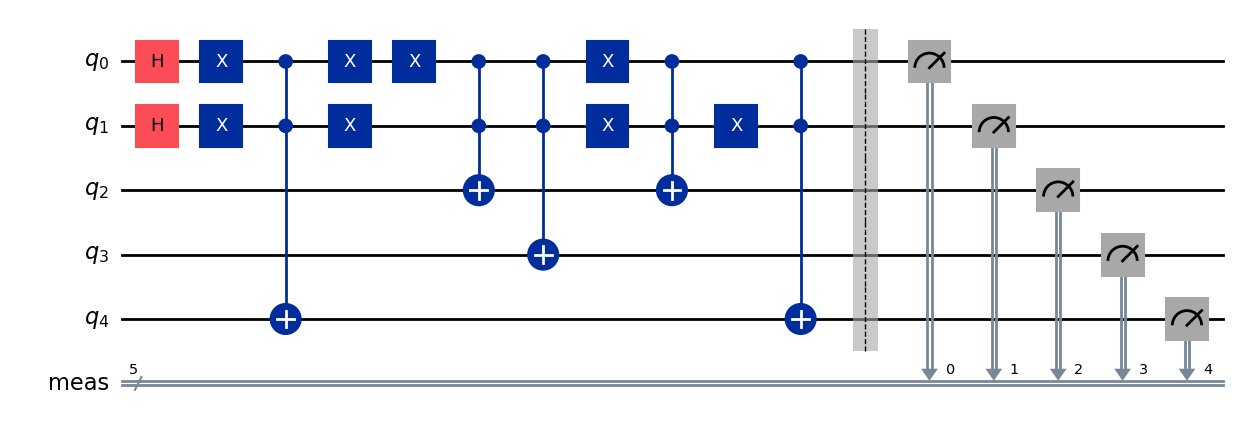

In [23]:
qc.draw(output="mpl", scale=1)

n_index: 3
n_val: 3


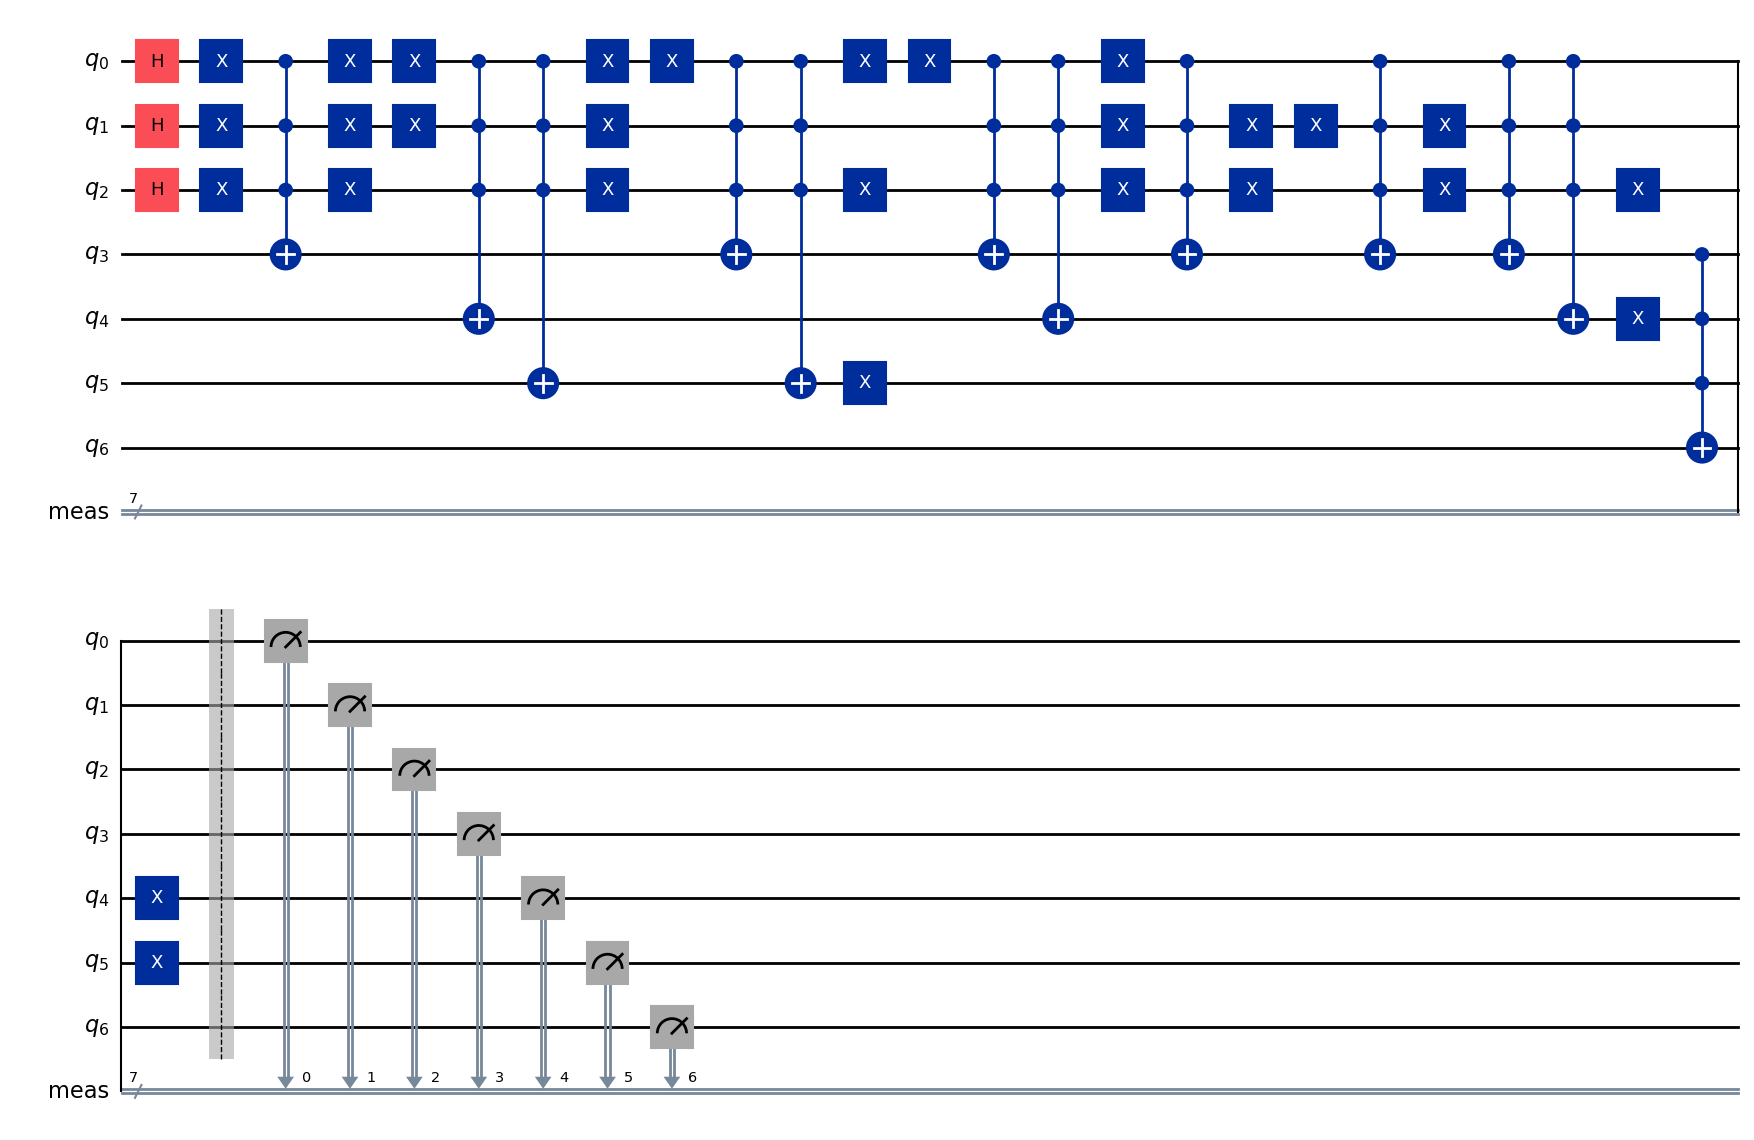

In [24]:
L = [1, 6, 5, 3, 1, 1, 3]
num = len(L)
n_index = math.ceil(math.log2(len(L)))  # log2(L)
n_val = math.ceil(math.log2(max(L) + 1))  # bits needed to store values (max = 4)
target = 1
print("n_index:", n_index)
print("n_val:", n_val)

# Circuit: index + value + flag
qc = QuantumCircuit(n_index + n_val + 1)

idx_qubits = list(range(n_index))
val_qubits = list(range(n_index, n_index + n_val))
flag_qubit = n_index + n_val

# 1. Put pointer in superposition
for q in idx_qubits:
    qc.h(q)

# 2. Encode value at each index into value_qubits
for idx, val in enumerate(L):
    idx_bin = format(idx, f"0{n_index}b")
    val_bin = format(val, f"0{n_val}b")

    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

    for j, bit in enumerate(reversed(val_bin)):
        if bit == "1":
            qc.mcx(idx_qubits, val_qubits[j], mode="noancilla")

    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

# 3. Apply filter: value == target
target_bin = format(target, f"0{n_val}b")
for j, bit in enumerate(reversed(target_bin)):
    if bit == "0":
        qc.x(val_qubits[j])

qc.mcx(val_qubits, flag_qubit, mode="noancilla")

for j, bit in enumerate(reversed(target_bin)):
    if bit == "0":
        qc.x(val_qubits[j])

# 4. Measure everything
qc.measure_all()
analyse(qc)
qc.draw(output="mpl", scale=1)

In [25]:
L = [1, 6, 5, 3, 1, 1, 3]


L_zero = {}
for i in range(0, len(L)):
    pick_val = L[i]  # Value I am going to swap in
    if pick_val in L_zero.keys():
        L_zero[pick_val] += 1
    else:
        L_zero[pick_val] = 1
# Make Prob
for k in L_zero.keys():
    L_zero[k] = "{:0.2f}%".format(L_zero[k] / len(L) * 100)
print(L_zero)

{1: '42.86%', 6: '14.29%', 5: '14.29%', 3: '28.57%'}


In [40]:
L = [1, 6, 5, 3, 1, 1, 3, 4, 1, 5]
n_index = math.ceil(math.log2(len(L)))  # log2(L)
n_val = math.ceil(math.log2(max(L) + 1))  # bits needed to store values (max = 4)

# Quantum circuit: index + value
qc = QuantumCircuit(n_index + n_val, n_val)

idx_qubits = list(range(n_index))
val_qubits = list(range(n_index, n_index + n_val))

# 1. Put pointer into uniform superposition
for i in idx_qubits:
    qc.h(i)

# 2. Encode value at each index
for idx, val in enumerate(L):
    idx_bin = format(idx, f"0{n_index}b")
    val_bin = format(val, f"0{n_val}b")

    # Flip index bits for control
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

    # Encode value bits using controlled-X
    for j, bit in enumerate(reversed(val_bin)):
        if bit == "1":
            qc.mcx(idx_qubits, val_qubits[j], mode="noancilla")

    # Uncompute index control bits
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

qc.barrier(range(n_val, n_index + n_val))


# 3. Measure only value qubits (like classical frequency)
for i in range(4, 7):
    qc.measure(i, i - 4)


# 4. Simulate
backend_sim = Aer.get_backend("qasm_simulator")
job_sim = backend_sim.run(qc, shots=2048)
counts = job_sim.result().get_counts()

# 5. Convert to percentage
freqs = {}
total = sum(counts.values())
for key in counts:
    val_decimal = int(key, 2)  # convert binary to int
    percent = (counts[key] / total) * 100
    freqs[val_decimal] = f"{percent:.2f}% {key:s}"

# Print output like classical version
print(freqs)


{4: '6.01% 100', 6: '6.93% 110', 1: '25.34% 001', 0: '36.67% 000', 3: '13.62% 011', 5: '11.43% 101'}


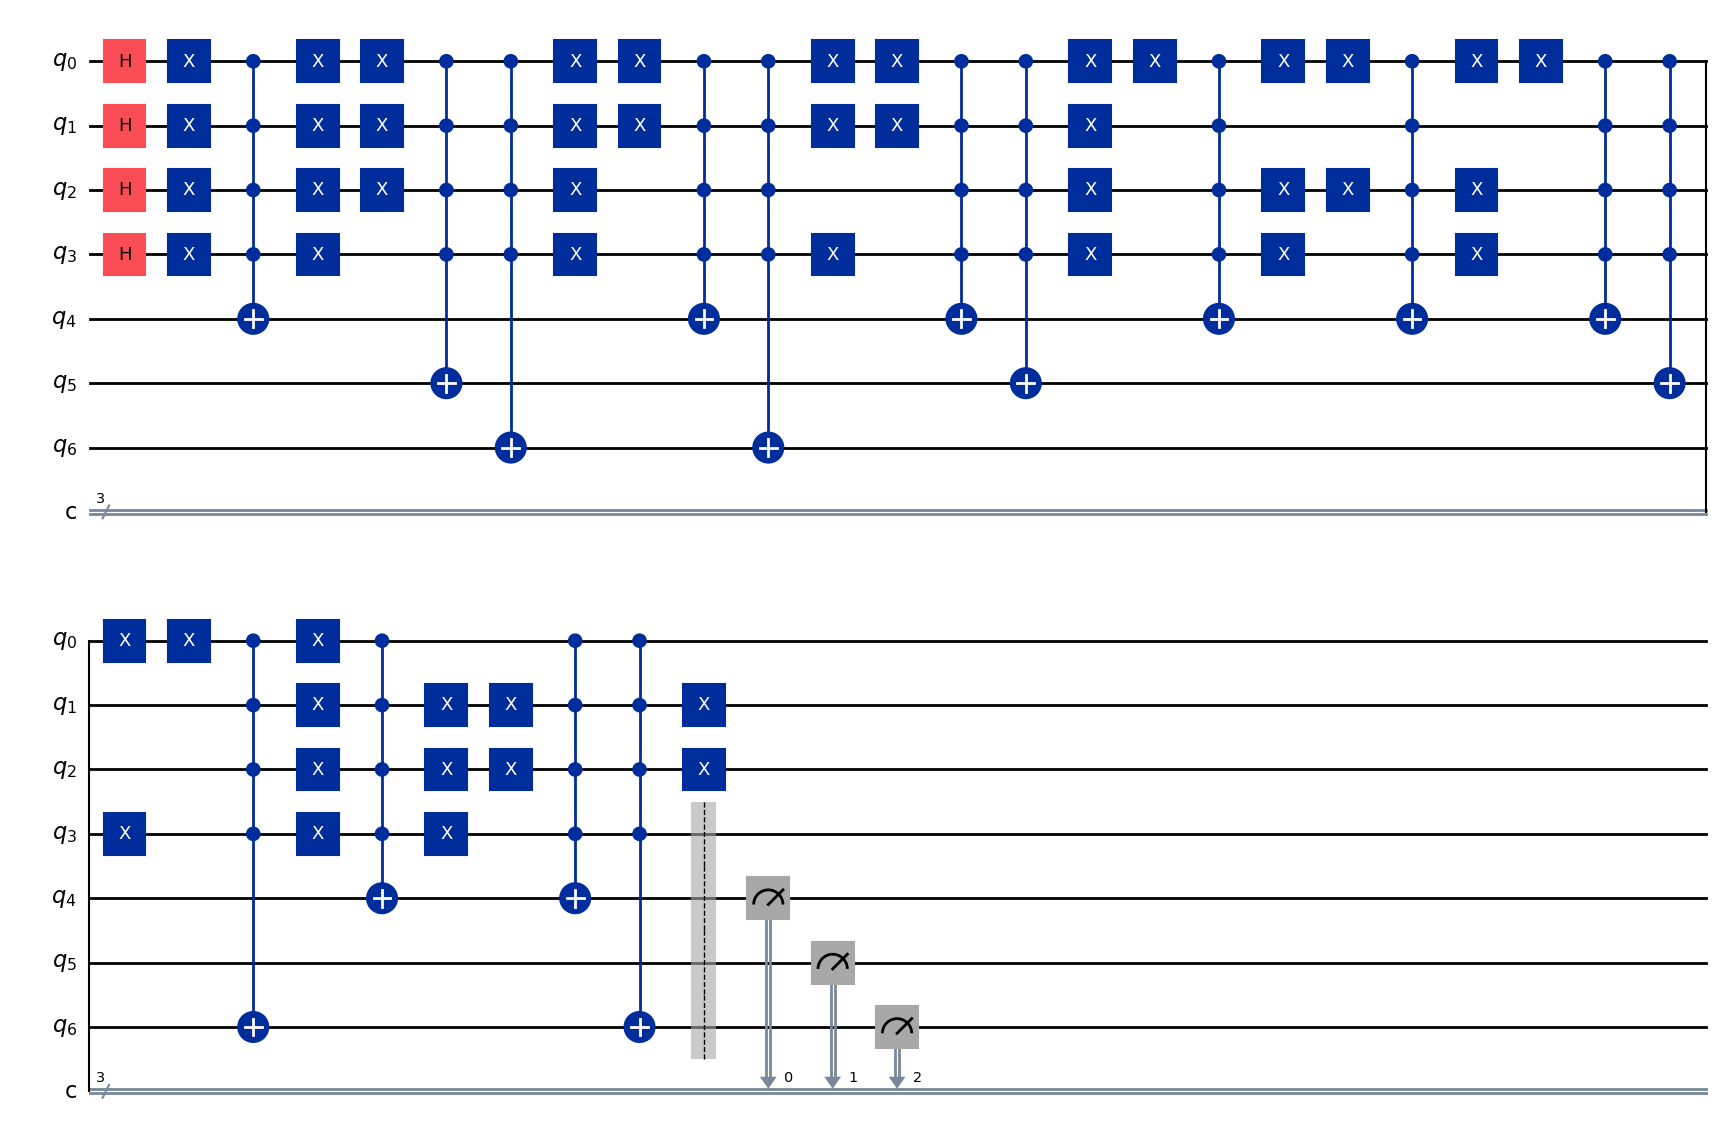

In [41]:
qc.draw(output="mpl", scale=1)

In [ ]:
# keep the circuit and do the grover to find 1